In [1]:
!pip install langchain_community
!pip install replicate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 3.4 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
from langchain_community.llms import Replicate
from google.colab import userdata

api_token = userdata.get('api_token')
os.environ["REPLICATE_API_TOKEN"] = api_token

-World Data-

In [12]:
# Load Excel
df = pd.read_excel("Data_annex_Energy_and_AI.xlsx", sheet_name="World Data", header=None)

In [13]:
# Basic cleaning: drop fully empty rows and columns
df.dropna(how='all', inplace=True)
df.dropna(axis=1, how='all', inplace=True)

In [16]:
# Fill blanks with empty strings, remove leading/trailing whitespace
df.fillna('', inplace=True)
df = df.astype(str).applymap(str.strip)

/tmp/ipython-input-16-2979166668.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna('', inplace=True)
/tmp/ipython-input-16-2979166668.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.astype(str).applymap(str.strip)


In [17]:
# Combine into one string
content_text = ""
for row in df.values:
    line = "\t".join(row)
    if line.strip() != "":
        content_text += line + "\n"

In [18]:
# Prompt for LLM
prompt = f"""
You are given structured tabular data extracted from an Excel file. It contains energy infrastructure metrics across different timeframes and AI growth scenarios.

The table includes:
- Historical data: 2020, 2023, 2024
- Scenario-based projections (2030 and 2035 only):
    - Base Case
    - Lift-Off
    - High Efficiency
    - Headwinds

Each metric is categorized into:
1. Installed capacity (GW) — includes Total, Hyperscale, Colocation and Service Provider, Enterprise
2. IT installed capacity (GW) — same breakdown
3. Power usage effectiveness (PUE) — Total and by category
4. Load factor (%) — Total and by category
5. Electricity consumption (TWh) — Total, IT, and their breakdowns

Your tasks are:

1. Treat 2020, 2023, and 2024 as **historical baselines**, and compare them with 2030 and 2035 **projections** under each scenario (Base Case, Lift-Off, High Efficiency, Headwinds).
2. Analyze each **metric separately** (do **not** compare across metrics like GW vs TWh).
3. For each metric:
   - Identify the historical trend (2020–2024),
   - Compare it with the scenario projections (2030–2035),
   - Highlight differences, accelerations, slowdowns, or reversals in growth.
4. If any scenario lacks values for a metric, acknowledge the gap, but do not estimate missing data.
5. Provide clear:
   - **Analytical results** per metric,
   - **Insights and findings** across time and scenarios,
   - **3 policy recommendations** based on your findings.

Here is the dataset:

{content_text}
"""


# Initialize LLM
parameters = {
  "top_k": 5,
  "top_p": 1.0,
  "max_tokens": 4096,
  "min_tokens": 0,
  "random_seed": None,
  "repetition_penalty": 1.0,
  "temperature": 0.7,
  "stopping_criteria": "length (256 tokens)",
  "stopping_sequence": None
}
llm = Replicate(model="ibm-granite/granite-3.3-8b-instruct", input=parameters)

# Run and print result
output = llm.invoke(prompt)
print("\n🧠 AI Analysis:\n")
print(output)


🧠 AI Analysis:

## Detailed Analysis and Policy Recommendations

This analysis focuses on the tabular data provided, examining each metric across the specified timeframes and scenarios. We will identify trends in historical data and compare them with scenario-based projections for 2030 and 2035.

### 1. Installed Capacity (GW)

#### Historical Trend (2020-2024)
- **Total**: Increased from 60 GW (2020) to 97 GW (2024), showing robust growth.
- **Hyperscale**: Grew from 20 GW to 36 GW.
- **Colocation and Service Provider**: Increased from 19 GW to 35 GW.
- **Enterprise**: Slight increase from 20 GW to 27 GW.
- **IT**: Rose from 38 GW to 68 GW.

#### Scenario Projections (2030-2035)
- **Base Case**: Total capacity reaches 226 GW (2030) and 277 GW (2035).
- **Lift-Off**: Even more aggressive, with total capacity at 305 GW (2030) and 404 GW (2035).
- **High Efficiency**: Moderate growth, with total capacity at 185 GW (2035).
- **Headwinds**: Slowest growth, with total capacity at 158 GW (2

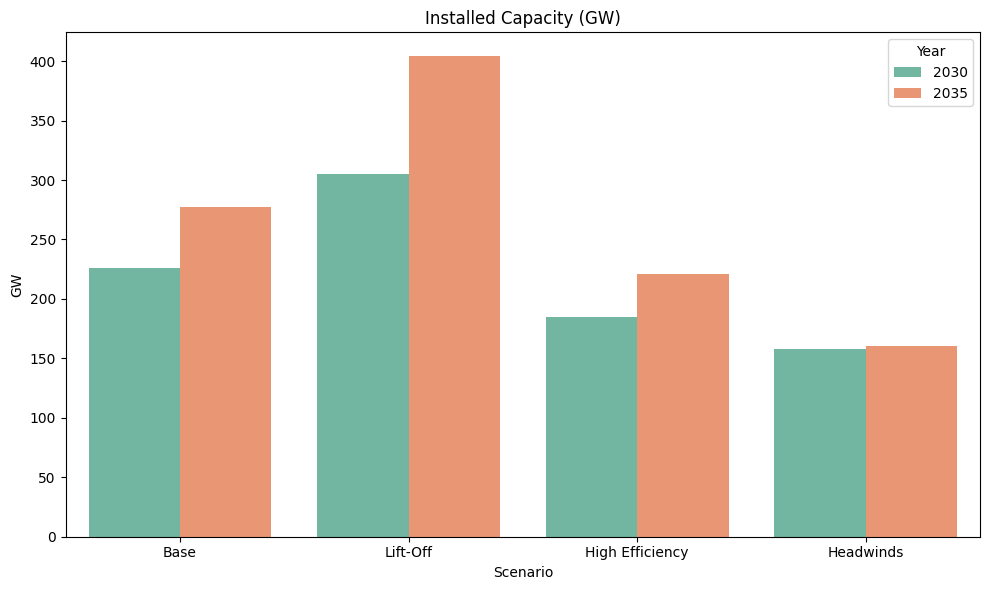

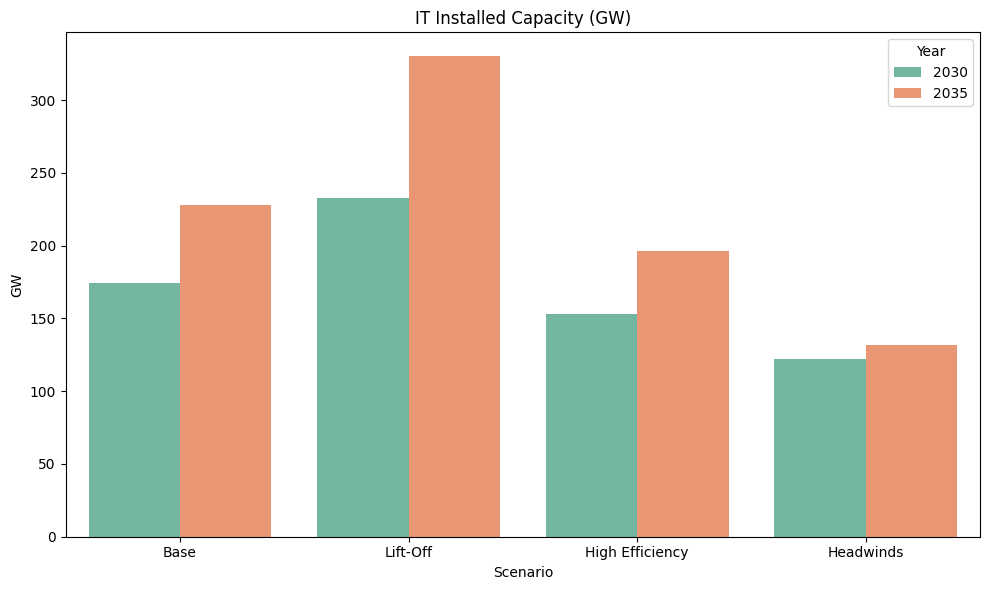

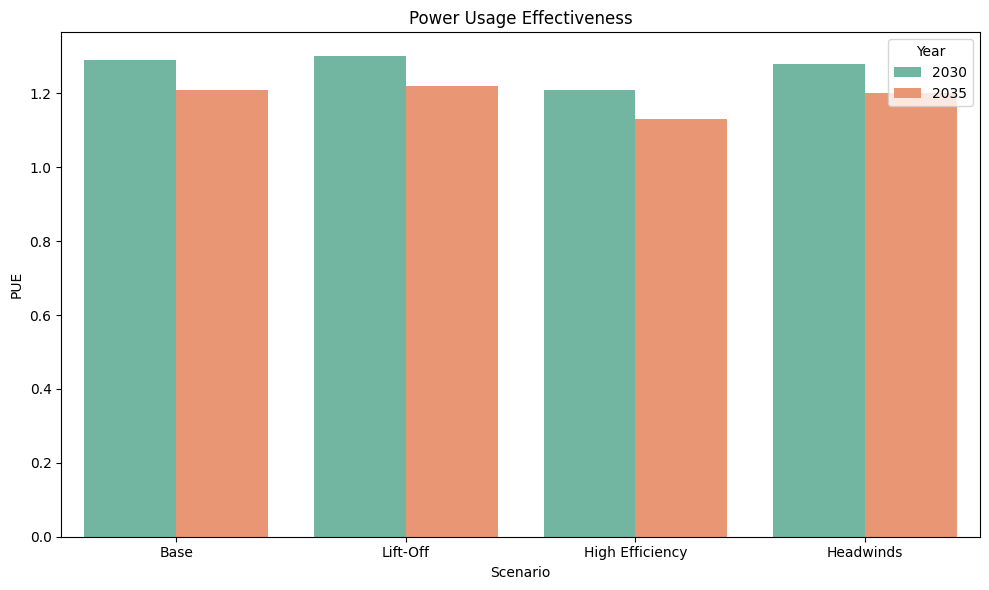

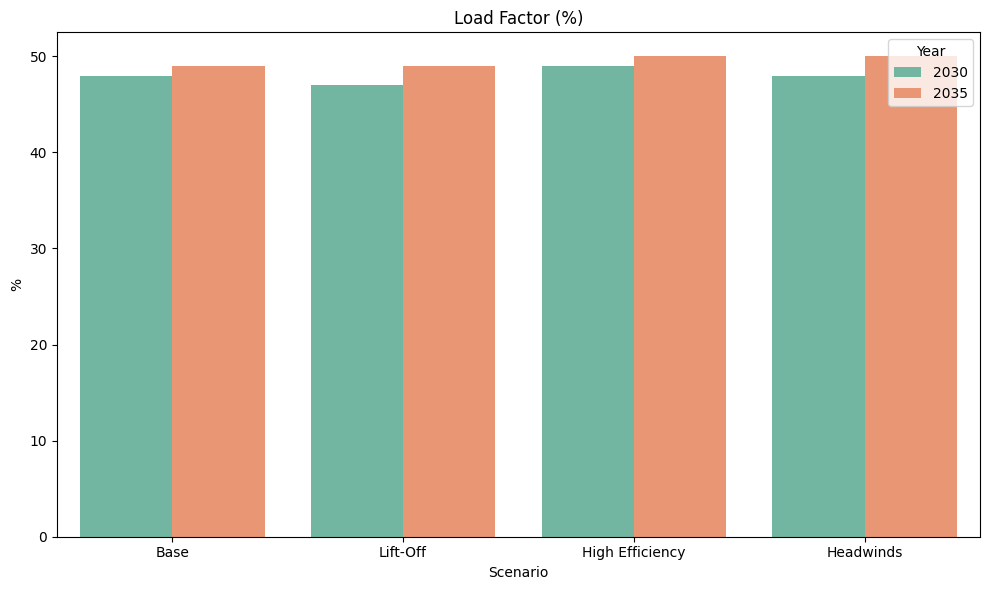

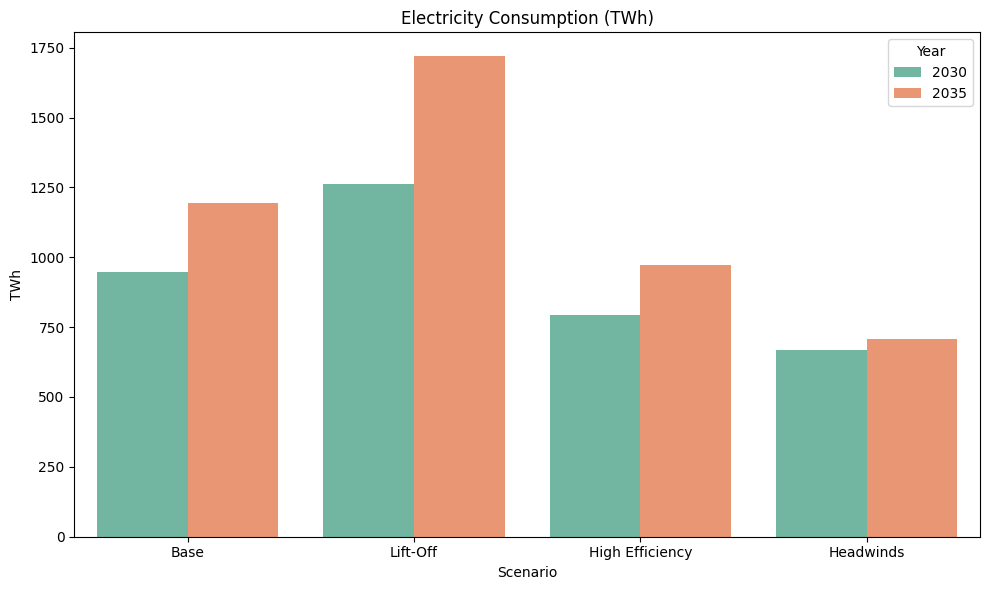

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define data
data = {
    "Metric": [
        "Installed Capacity (GW)",
        "IT Installed Capacity (GW)",
        "Power Usage Effectiveness",
        "Load Factor (%)",
        "Electricity Consumption (TWh)"
    ],
    "Base 2030":           [226, 174, 1.29, 48, 946],
    "Base 2035":           [277, 228, 1.21, 49, 1193],
    "Lift-Off 2030":       [305, 233, 1.30, 47, 1264],
    "Lift-Off 2035":       [404, 330, 1.22, 49, 1719],
    "High Efficiency 2030":[185, 153, 1.21, 49, 792],
    "High Efficiency 2035":[221, 196, 1.13, 50, 972],
    "Headwinds 2030":      [158, 122, 1.28, 48, 669],
    "Headwinds 2035":      [160, 132, 1.20, 50, 707],
}

df = pd.DataFrame(data)
df.set_index("Metric", inplace=True)

# Barplot function
def plot_metric(df, metric_name, ylabel, figsize=(10, 6)):
    metric_data = df.loc[metric_name]

    # Convert Series to DataFrame
    plot_df = metric_data.reset_index()
    plot_df.columns = ["Scenario_Year", "Value"]

    # Extract scenario and year properly
    def split_scenario_year(s):
        if s.startswith("High Efficiency"):
            return "High Efficiency", s.split()[-1]
        return " ".join(s.split()[:-1]), s.split()[-1]

    plot_df[["Scenario", "Year"]] = plot_df["Scenario_Year"].apply(lambda x: pd.Series(split_scenario_year(x)))

    # Plot
    plt.figure(figsize=figsize)
    sns.barplot(data=plot_df, x="Scenario", y="Value", hue="Year", palette="Set2")

    plt.title(metric_name)
    plt.ylabel(ylabel)
    plt.xlabel("Scenario")
    plt.legend(title="Year")
    plt.tight_layout()
    plt.show()

# Plot all metrics
plot_metric(df, "Installed Capacity (GW)", "GW")
plot_metric(df, "IT Installed Capacity (GW)", "GW")
plot_metric(df, "Power Usage Effectiveness", "PUE")
plot_metric(df, "Load Factor (%)", "%")
plot_metric(df, "Electricity Consumption (TWh)", "TWh")


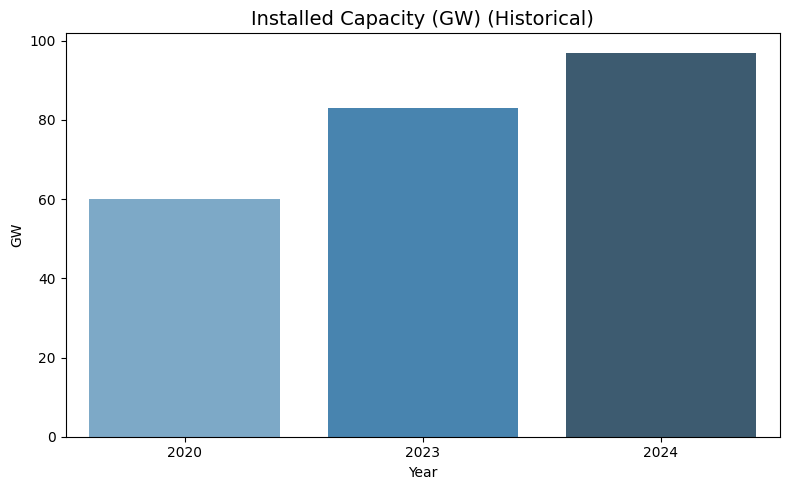

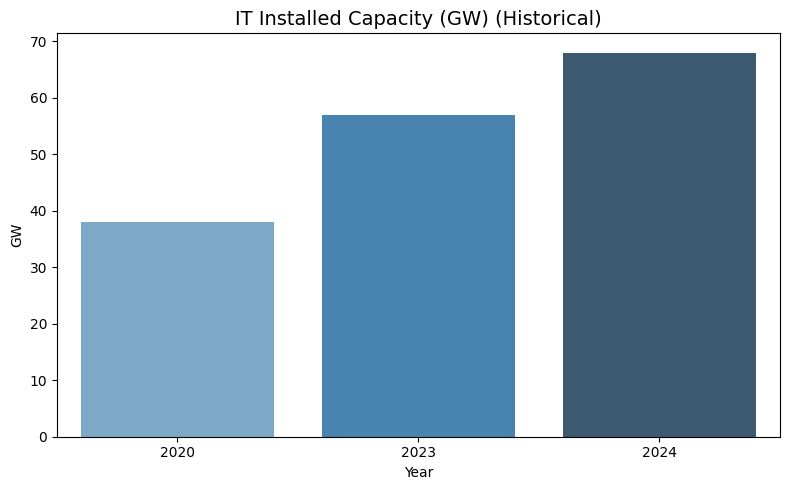

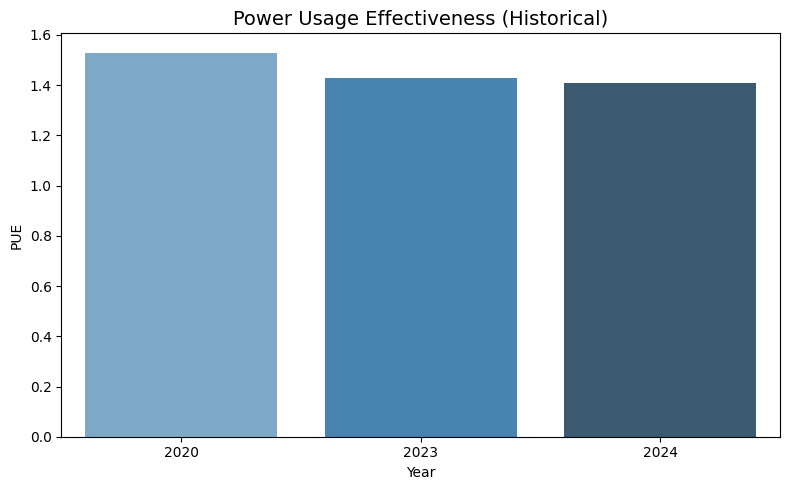

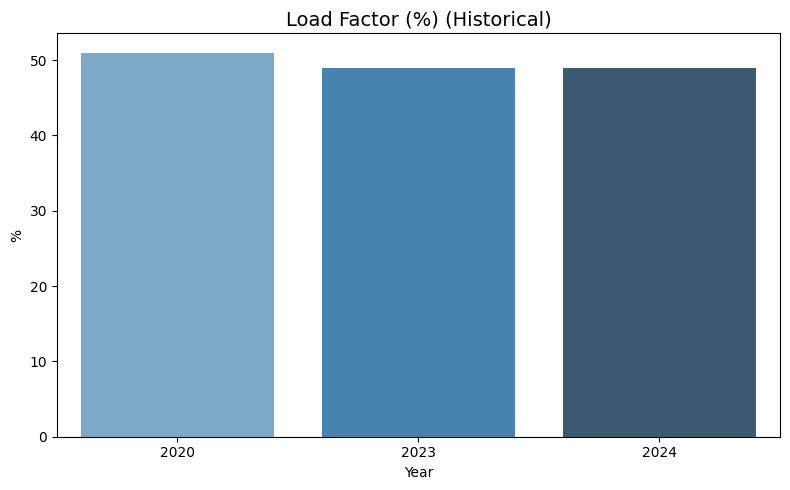

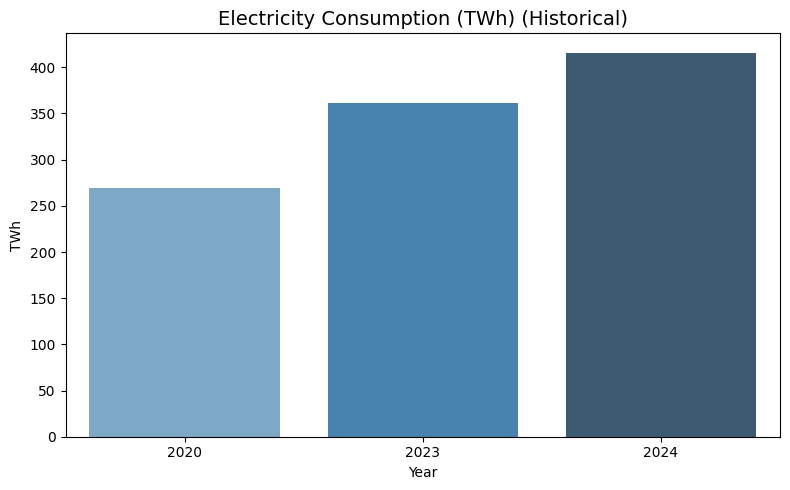

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample historical data
data_hist = {
    "Metric": [
        "Installed Capacity (GW)",
        "IT Installed Capacity (GW)",
        "Power Usage Effectiveness",
        "Load Factor (%)",
        "Electricity Consumption (TWh)"
    ],
    "2020": [60, 38, 1.53, 51, 269],
    "2023": [83, 57, 1.43, 49, 361],
    "2024": [97, 68, 1.41, 49, 416]
}

df_hist = pd.DataFrame(data_hist)
df_hist.set_index("Metric", inplace=True)

# Plotting function
def plot_historical_metric(df, metric_name, ylabel, figsize=(8, 5)):
    metric_data = df.loc[metric_name]
    hist_df = metric_data.reset_index()
    hist_df.columns = ["Year", "Value"]

    plt.figure(figsize=figsize)
    sns.barplot(
        data=hist_df,
        x="Year",
        y="Value",
        hue="Year",
        palette="Blues_d",
        legend=False
    )

    plt.title(f"{metric_name} (Historical)", fontsize=14)
    plt.ylabel(ylabel)
    plt.xlabel("Year")
    plt.tight_layout()
    plt.show()

# Plot each metric
plot_historical_metric(df_hist, "Installed Capacity (GW)", "GW")
plot_historical_metric(df_hist, "IT Installed Capacity (GW)", "GW")
plot_historical_metric(df_hist, "Power Usage Effectiveness", "PUE")
plot_historical_metric(df_hist, "Load Factor (%)", "%")
plot_historical_metric(df_hist, "Electricity Consumption (TWh)", "TWh")


-Regional Data-

In [3]:
# Load Excel
df = pd.read_excel("Data_annex_Energy_and_AI.xlsx", sheet_name="Regional Data", header=None)

In [4]:
# Basic cleaning: drop fully empty rows and columns
df.dropna(how='all', inplace=True)
df.dropna(axis=1, how='all', inplace=True)

In [5]:
# Fill blanks with empty strings, remove leading/trailing whitespace
df.fillna('', inplace=True)
df = df.astype(str).applymap(str.strip)

/tmp/ipython-input-5-2979166668.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna('', inplace=True)
/tmp/ipython-input-5-2979166668.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.astype(str).applymap(str.strip)


In [6]:
# Combine into one string
content_text = ""
for row in df.values:
    line = "\t".join(row)
    if line.strip() != "":
        content_text += line + "\n"

In [8]:
# Prompt for LLM
prompt = f"""
You are given tabular energy infrastructure data across years (2020–2024) and projections for 2030 (Base Case).
It includes:
- Installed capacity (GW)
- IT installed capacity (GW)
- Power usage effectiveness (PUE)
- Load factor (%)
- Electricity consumption (TWh)
- IT electricity consumption (TWh)

The data is structured by region:
- World, North America, United States, Central and South America, Europe, Africa, Middle East, Asia Pacific, and China

Your tasks:

1. **Analyze each metric across all regions individually**.
   - Highlight growth trends from 2020 → 2023 → 2024 → 2030 (Base Case).
   - Do NOT omit any regions, even if values are small.

2. For each region:
   - Summarize major changes over time for all metrics.
   - Compare how that region is performing vs global average.

3. **Identify insights** such as:
   - High-growth regions
   - Efficiency improvements or decline
   - Disparities between IT infrastructure and overall consumption

4. **Highlight risks or opportunities**, e.g.:
   - Digital divide
   - Sustainability concerns
   - Energy dependencies

5. **Conclude with 3 region-sensitive policy recommendations** that address:
   - Infrastructure investment
   - Sustainability
   - Digital equality

Here is the table data:

{content_text}
"""



# Initialize LLM
parameters = {
  "top_k": 5,
  "top_p": 1.0,
  "max_tokens": 4096,
  "min_tokens": 0,
  "random_seed": None,
  "repetition_penalty": 1.0,
  "temperature": 0.7,
  "stopping_criteria": "length (256 tokens)",
  "stopping_sequence": None
}
llm = Replicate(model="ibm-granite/granite-3.3-8b-instruct", input=parameters)

# Run and print result
output = llm.invoke(prompt)
print("\n🧠 AI Analysis:\n")
print(output)


🧠 AI Analysis:

## Detailed Analysis of Energy Infrastructure Data Across Regions (2020–2030 Base Case)

### 1. Individual Metric Analysis by Region

#### Installed Capacity (GW)

**World:** 
- 2020: 60.0 GW
- 2023: 83.0 GW
- 2024: 97.0 GW
- 2030 (Base Case): 226 GW

**North America:**
- 2020: 24.0 GW
- 2023: 35.0 GW
- 2024: 43.0 GW
- 2030 (Base Case): 102 GW

**United States:**
- 2020: 23.0 GW
- 2023: 35.0 GW
- 2024: 42.0 GW
- 2030 (Base Case): 100 GW

**Central and South America:**
- 2020: 0.3 GW
- 2023: 0.4 GW
- 2024: 0.4 GW
- 2030 (Base Case): 0.8 GW

**Europe:**
- 2020: 13.0 GW
- 2023: 15.0 GW
- 2024: 16.0 GW
- 2030 (Base Case): 27 GW

**Africa:**
- 2020: 0.3 GW
- 2023: 0.3 GW
- 2024: 0.4 GW
- 2030 (Base Case): 0.7 GW

**Middle East:**
- 2020: 0.3 GW
- 2023: 0.3 GW
- 2024: 0.4 GW
- 2030 (Base Case): 0.7 GW

**Asia Pacific:**
- 2020: 21.0 GW
- 2023: 30.0 GW
- 2024: 36.0 GW
- 2030 (Base Case): 92 GW

**China:**
- 2020: 14.0 GW
- 2023: 20.0 GW
- 2024: 24.0 GW
- 2030 (Base Case): 67 

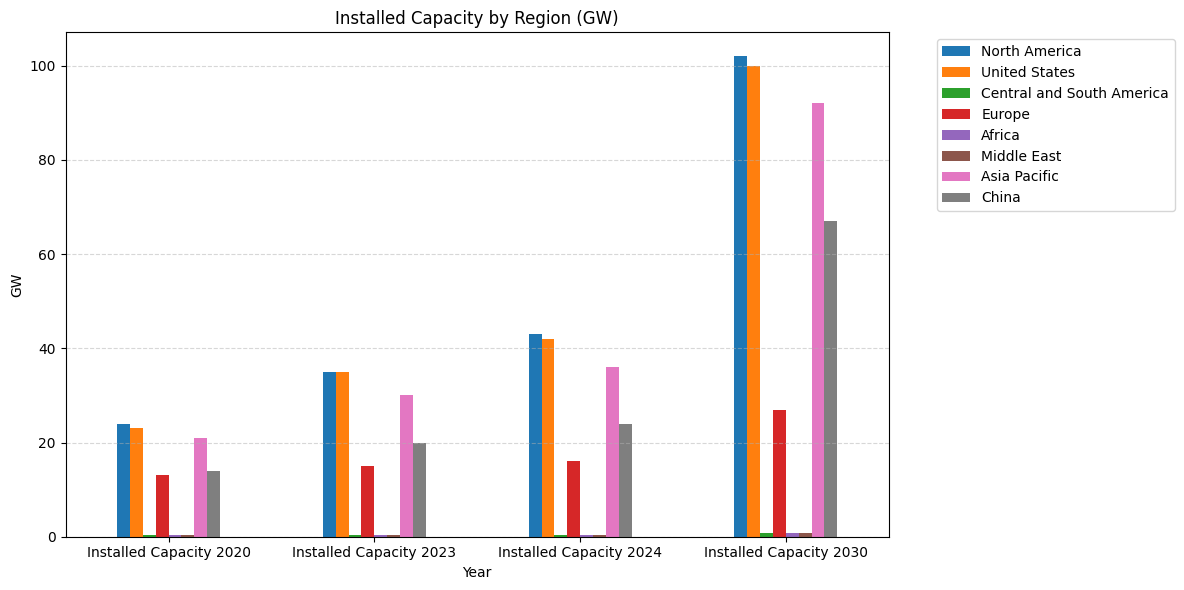

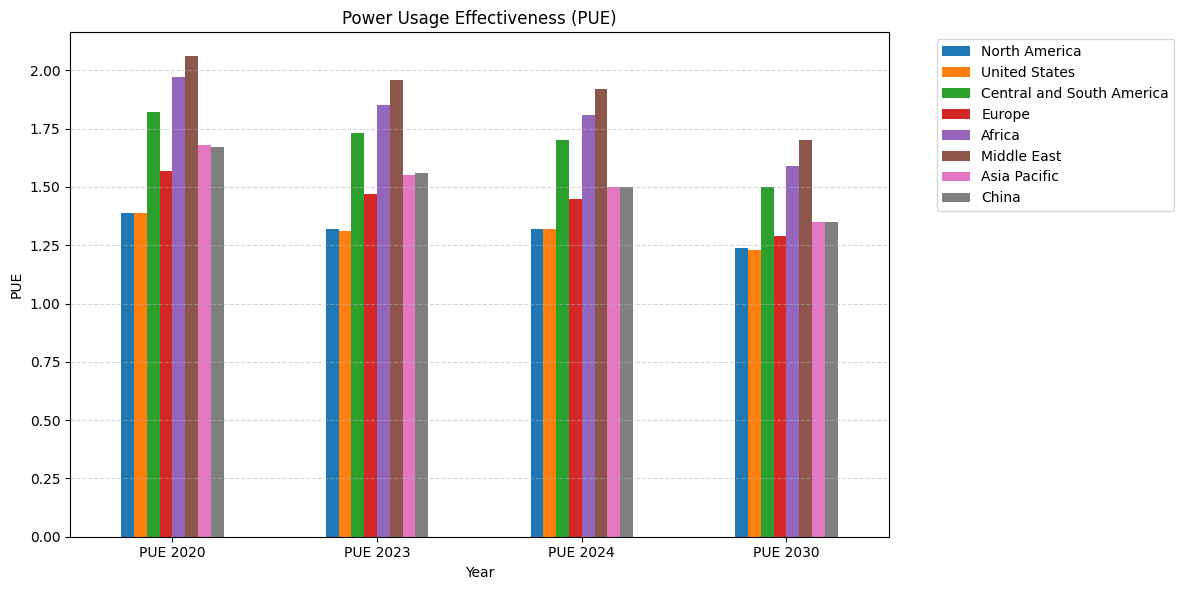

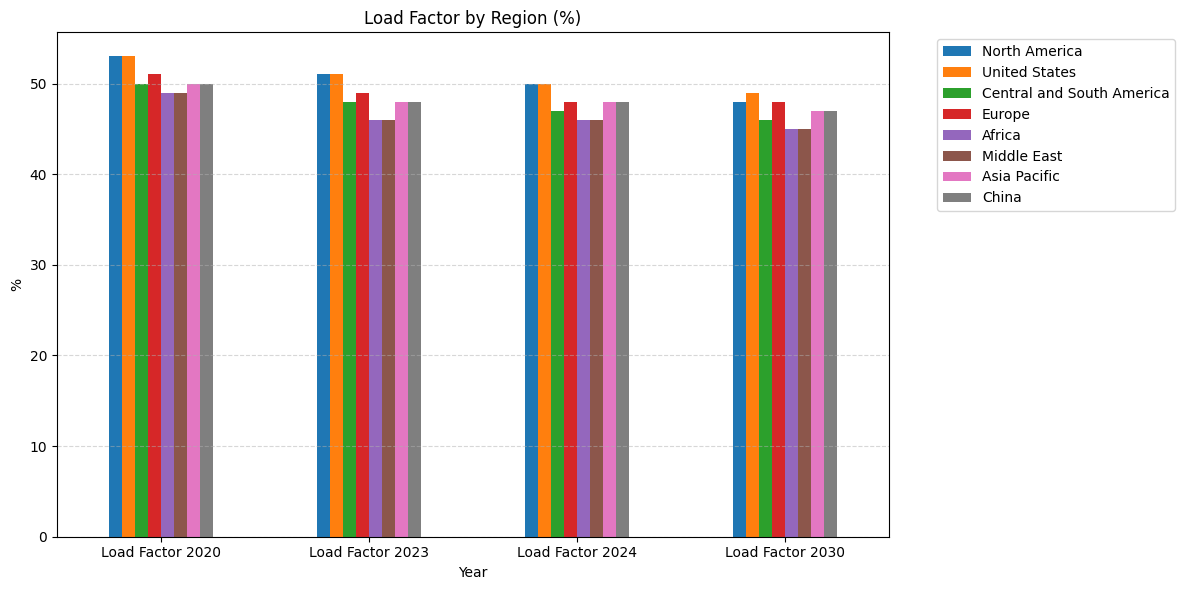

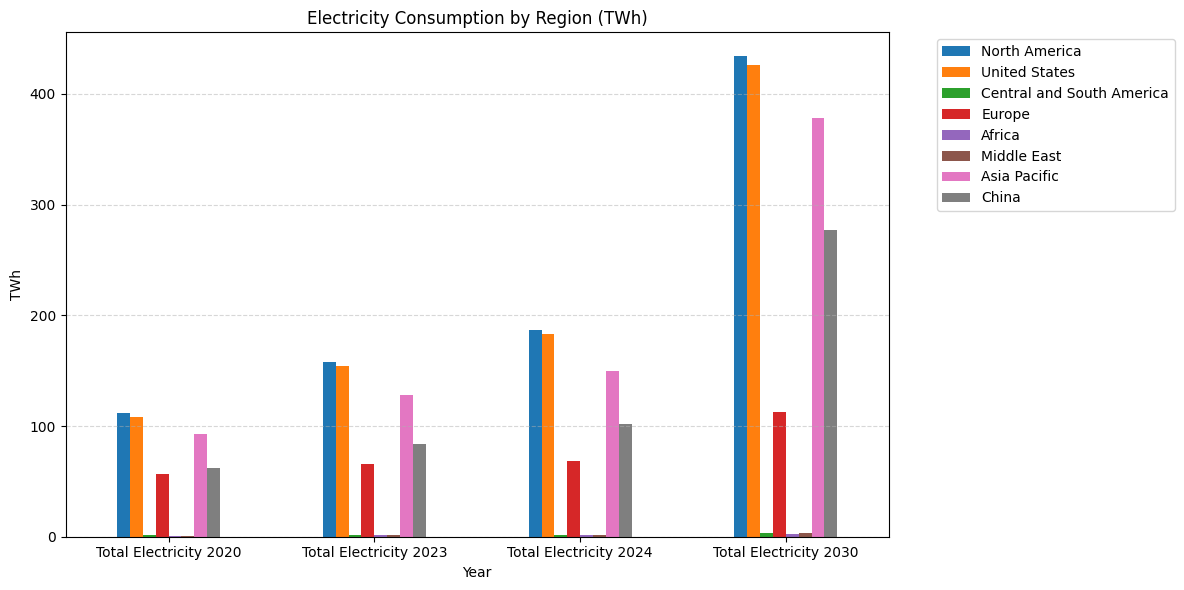

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample Regional Data
data = {
    "Region": [
        "North America", "United States", "Central and South America",
        "Europe", "Africa", "Middle East", "Asia Pacific", "China"
    ],
    "Installed Capacity 2020": [24, 23, 0.3, 13, 0.3, 0.3, 21, 14],
    "Installed Capacity 2023": [35, 35, 0.4, 15, 0.3, 0.3, 30, 20],
    "Installed Capacity 2024": [43, 42, 0.4, 16, 0.4, 0.4, 36, 24],
    "Installed Capacity 2030": [102, 100, 0.8, 27, 0.7, 0.7, 92, 67],

    "PUE 2020": [1.39, 1.39, 1.82, 1.57, 1.97, 2.06, 1.68, 1.67],
    "PUE 2023": [1.32, 1.31, 1.73, 1.47, 1.85, 1.96, 1.55, 1.56],
    "PUE 2024": [1.32, 1.32, 1.70, 1.45, 1.81, 1.92, 1.50, 1.50],
    "PUE 2030": [1.24, 1.23, 1.50, 1.29, 1.59, 1.70, 1.35, 1.35],

    "Load Factor 2020": [53, 53, 50, 51, 49, 49, 50, 50],
    "Load Factor 2023": [51, 51, 48, 49, 46, 46, 48, 48],
    "Load Factor 2024": [50, 50, 47, 48, 46, 46, 48, 48],
    "Load Factor 2030": [48, 49, 46, 48, 45, 45, 47, 47],

    "Total Electricity 2020": [112, 108, 1.5, 57, 1.1, 1.1, 93, 62],
    "Total Electricity 2023": [158, 154, 1.5, 66, 1.3, 1.3, 128, 84],
    "Total Electricity 2024": [187, 183, 1.7, 68, 1.4, 1.5, 150, 102],
    "Total Electricity 2030": [434, 426, 3.3, 113, 2.9, 3.0, 378, 277],
}

df = pd.DataFrame(data)

# Plotting
def plot_metric(df, columns, title, ylabel, filename):
    df_plot = df[["Region"] + columns].set_index("Region")
    df_plot.T.plot(kind="bar", figsize=(12, 6))
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel("Year")
    plt.xticks(rotation=0)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.savefig(filename)
    plt.show()

# Installed Capacity (GW)
plot_metric(df, ["Installed Capacity 2020", "Installed Capacity 2023", "Installed Capacity 2024", "Installed Capacity 2030"],
            "Installed Capacity by Region (GW)", "GW", "installed_capacity.png")

# Power Usage Effectiveness (PUE)
plot_metric(df, ["PUE 2020", "PUE 2023", "PUE 2024", "PUE 2030"],
            "Power Usage Effectiveness (PUE)", "PUE", "pue.png")

# Load Factor (%)
plot_metric(df, ["Load Factor 2020", "Load Factor 2023", "Load Factor 2024", "Load Factor 2030"],
            "Load Factor by Region (%)", "%", "load_factor.png")

# Total Electricity Consumption (TWh)
plot_metric(df, ["Total Electricity 2020", "Total Electricity 2023", "Total Electricity 2024", "Total Electricity 2030"],
            "Electricity Consumption by Region (TWh)", "TWh", "electricity_consumption.png")
